# CytoData 2018 - Hackathon
## Creating a submission entry 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import cytodata

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 1. Load datasets
**Datasets available**: BBBC022 and BBBC036

**Data partitions**: Train and Test

**Features**: CellProfiler and DeepLearning

In [2]:
FEATURES = "CellProfiler"

bbbc022_train = cytodata.load_dataset("BBBC022", partition="Train", features=FEATURES)
bbbc036_train = cytodata.load_dataset("BBBC036", partition="Train", features=FEATURES)

bbbc022_train.loc[bbbc022_train.Metadata_pert_id.isna(),"Metadata_pert_id"] = "DMSO"
bbbc036_train.loc[bbbc036_train.Metadata_pert_id.isna(),"Metadata_pert_id"] = "DMSO"

if FEATURES == "DeepLearning":
    bbbc022_train = bbbc022_train.drop(columns=["Plate_Well"])
    bbbc036_train = bbbc036_train.drop(columns=["Plate_Well"])

1it [00:21, 21.46s/it]
1it [00:28, 28.17s/it]


In [3]:
print("Shape of datasets:", bbbc022_train.shape, bbbc036_train.shape)

Shape of datasets: (6462, 1803) (18929, 1801)


In [4]:
# Find common feature set

features_022 = set([f for f in bbbc022_train.columns if not f.startswith("Metadata")])
features_036 = set([f for f in bbbc036_train.columns if not f.startswith("Metadata")])

common_features = list(features_022.intersection(features_036))
print("Number of common features:", len(common_features))

Number of common features: 1783


# 2. Build a model for processing data

In this example, we compute normalization parameters using control wells in the training set.

In [5]:
class NormalizeUsingJointControls(object):
    
    # Initialization function
    
    def __init__(self, dfA, dfB, common_features):
        self.dfA = dfA
        self.dfB = dfB
        self.common_features = common_features
        
    # Learning procedure
    
    def fit(self, control_column_A, control_column_B, control_value):
        # Collect control wells from both datasets
        
        controls_A = self.dfA[self.dfA[control_column_A] == control_value][self.common_features]
        controls_B = self.dfB[self.dfB[control_column_B] == control_value][self.common_features]
        
        # Compute control statistics
        
        controls = pd.concat([controls_A, controls_B])
        self.mean_ctl = controls.mean()
        self.std_ctl = controls.std()

        # Remove features with no variance
        
        no_variance = self.std_ctl[self.std_ctl == 0].index
        self.common_features = [c for c in self.common_features if c not in no_variance]
        
    # Transformation procedure
    
    def transform(self, df):
        # Z-score features
        
        norm = df.copy()
        norm[self.common_features] = df[self.common_features] - self.mean_ctl[self.common_features]
        norm[self.common_features] = norm[self.common_features] / self.std_ctl[self.common_features]
        
        return norm


In [6]:
# Create and fit normalization model 

model = NormalizeUsingJointControls(bbbc022_train, bbbc036_train, common_features)
model.fit(
    control_column_A="Metadata_pert_id", 
    control_column_B="Metadata_pert_id", 
    control_value="DMSO"
)

# Apply normalization model to training data

normalized_022 = model.transform(bbbc022_train)
normalized_036 = model.transform(bbbc036_train)

# 3. Load test sets and apply learned model

The test data is not used for training, but needs to be transformed using the same model.

In [7]:
# Load test data

bbbc022_test = cytodata.load_dataset("BBBC022", "Test", FEATURES)
bbbc036_test = cytodata.load_dataset("BBBC036", "Test", FEATURES)

print("Test wells: BBBC022={}, BBBC036={}".format(bbbc022_test.shape[0], bbbc036_test.shape[0]))

1it [00:01,  1.89s/it]
1it [00:06,  6.47s/it]

Test wells: BBBC022=1120, BBBC036=2177


In [8]:
# Apply normalization model

normalized_022_test = model.transform(bbbc022_test)
normalized_036_test = model.transform(bbbc036_test)

In [9]:
# Merge training and test sets

normalized_022 = pd.concat([normalized_022, normalized_022_test])
normalized_036 = pd.concat([normalized_036, normalized_036_test])

# 4. Aggregate profiles
All the processes above work at with well-level data, also known as replicate-level data. Now we need to aggregate and transform well-level data into treatment-level profiles. In this example, we use the mean profiling technique.

In [10]:
# Compute mean profile of treatments (accross replicates)

aggregated_022 = normalized_022.groupby(["Metadata_pert_id"])[common_features].mean().reset_index()
aggregated_036 = normalized_036.groupby(["Metadata_pert_id"])[common_features].mean().reset_index()

aggregated_022 = aggregated_022[aggregated_022.Metadata_pert_id != "DMSO"]
aggregated_036 = aggregated_036[aggregated_036.Metadata_pert_id != "DMSO"]

In [11]:
print("Shape of treatment-level data", aggregated_022.shape, aggregated_036.shape)

Shape of treatment-level data (1542, 1784) (2238, 1784)


# 5. Compute connectivity matrix
With treatment-level profiles, proceed to match treatments from one database to the other. In this example we match treatments using Pearson Correlation similarity function.

**Important**: the values of the connectivity matrix are assumed to be similarity values (higher scores mean higher connectivity) as opposed to distance values (higher scores mean longer distances and low connectivity).

In [12]:
# Similarity matrix using Pearson Correlation

corr_matrix = np.corrcoef(x=aggregated_022[common_features], y=aggregated_036[common_features])
corr_matrix = corr_matrix[0:aggregated_022.shape[0], aggregated_022.shape[0]:]

In [13]:
# Statistics of the connectivity matrix

print("Connectivity matrix shape:", corr_matrix.shape)
print("Max: {}, Min: {}, Mean: {}, Median: {}".format(np.max(corr_matrix), np.min(corr_matrix), np.mean(corr_matrix), np.median(corr_matrix)))

Connectivity matrix shape: (1542, 2238)
Max: 0.971967141265076, Min: -0.91657480070411, Mean: -0.5547182377271731, Median: -0.6238469683605599


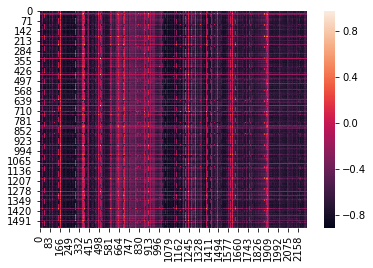

In [14]:
# Visualization of the connectivity matrix

sb.heatmap(corr_matrix)

# 6. Create submission file

Finally, save the connectivity matrix using treatment-level profiles, with columns and rows labeled with the ID of treatments. 

In [15]:
submission = pd.DataFrame(
    data=corr_matrix, 
    index=aggregated_022.Metadata_pert_id, 
    columns=aggregated_036.Metadata_pert_id)

submission = submission.reset_index()

In [16]:
SUBMISSION_NAME = "cytodata-baseline-day2"
submission.to_csv(SUBMISSION_NAME + ".csv", index=False)